### Data Preparation

Any trading strategy or ML model starts with some data. For this project we will use [this kaggle dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs), which contains historic daily OHLC data for various securities. So to start we will download this dataset from kaggle. 



The dataset contains many different securities, to narrow it down im just gonna use this list of various historic S&P 500 stocks that I got from a university course.

In [1]:
import pandas as pd
tickers = pd.read_csv('SP Tickers.csv')
tickers = set(tickers['symbol'].tolist())

In [2]:
len(tickers)

773

Currently all the different ticker data is in its own files, so we can load them all individually and combine them into one giant dataframe `stock_df`

In [3]:
import os
import pandas as pd
from pandas.errors import EmptyDataError

dataframes = []
directory = os.path.join(os.getcwd() + '/Stocks')

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        ticker = filename.replace('.us.txt', '').upper()
        file_path = os.path.join(directory, filename)

        if ticker not in tickers: # if the ticker isnt in our list, ignore it
          continue

        try:
            df = pd.read_csv(file_path)
            df['Ticker'] = ticker
            df.sort_values('Date', inplace=True)
            dataframes.append(df)
        except EmptyDataError: # some of the files have no contents so read_csv throws error
          pass

stock_df = pd.concat(dataframes, ignore_index=True)

stock_df['Date'] = pd.to_datetime(stock_df['Date'], format='%Y-%m-%d')

The next step is to create some more interesting features and partition the dataset into training and testing periods.

C:\Users\dylan\AppData\Local\Temp\ipykernel_7620\2087222907.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Count', data=rows_per_year, palette='viridis')


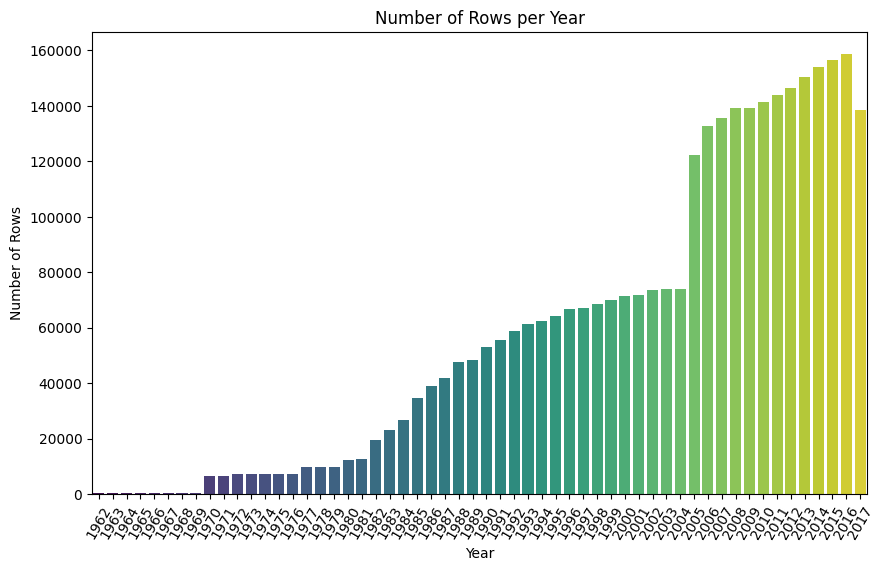

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df = stock_df.copy()
df['Year'] = df['Date'].dt.year

rows_per_year = df.groupby('Year').size()

rows_per_year = rows_per_year.reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Count', data=rows_per_year, palette='viridis')
plt.title('Number of Rows per Year')
plt.xlabel('Year')
plt.ylabel('Number of Rows')
plt.xticks(rotation=60)
plt.show()

We can see that there is a lot of data from 2005-2017. For the training set we will use 2010-2012 and for backtesting we will use 2013-2017.

In [5]:
TRAINING_START_DATE = pd.to_datetime("2010-01-01")
TRAINING_END_DATE = pd.to_datetime("2012-12-31")

BACKTEST_START_DATE = pd.to_datetime("2013-01-01")
BACKTEST_END_DATE = pd.to_datetime("2017-12-31")

Now to create some features, I found the [Technical Analysis (TA)](https://github.com/bukosabino/ta) library to be extreamly helpfull for this.

The library contains utilities for generating various volumne, momentum, volatility, and trend indicators from OHLC data. And convieniently you can just add them all with `ta.add_all_ta_features` which is what I will do.

In [6]:
import pandas as pd
import numpy as np
import ta  # Technical analysis library

def get_features_df(stock_df, tickers, start_date, end_date):
    filtered_df = stock_df.loc[
        (stock_df['Ticker'].isin(tickers)) & 
        (stock_df['Date'] >= start_date) & 
        (stock_df['Date'] <= end_date)
    ].copy()

    def process_ticker(ticker_df):
        if len(ticker_df) > 100:
            ticker_df = ta.add_all_ta_features(
                ticker_df, open="Open", high="High", low="Low", close="Close", volume="Volume"
            )
            ticker_df['trading_signal'] = np.where(ticker_df['Close'] >= ticker_df['Open'], 1, -1)
            ticker_df.drop(['trend_psar_up', 'trend_psar_down'], axis=1, inplace=True)
            ticker_df.dropna(inplace=True)
            ticker_df['trading_signal'] = ticker_df['trading_signal'].shift(-1)
            return ticker_df.iloc[:-1]
        
        return pd.DataFrame()
    
    processed_df = filtered_df.groupby('Ticker').apply(process_ticker).reset_index(drop=True)
    
    return processed_df

Note the `trading_signal` column, this indicates whether the price goes up or down on a given day and will be used as the target for our models. The advantage of this is that its relatively simple, however it does not provide a straightforward way to model the risk of a given shift.

In [7]:
from pathlib import Path

train_df_file = Path("train_df.csv")
if train_df_file.is_file():
    train_df = pd.read_csv('train_df.csv')
else:
    train_df = get_features_df(stock_df, tickers, TRAINING_START_DATE, TRAINING_END_DATE)
    train_df.to_csv('train_df.csv')
len(train_df)

384423

Now we have 380,000 rows of data with our 90 ish features.

In [8]:
train_df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,OpenInt,Ticker,volume_adi,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,trading_signal
0,0,2010-04-16,23.991,24.235,23.673,23.810,8547894.0,0.0,A,8.414133e+07,...,1.697406,-0.064102,15.903976,3.240167,12.663809,23.121403,-0.997921,-1.002934,12.694055,-1.0
1,1,2010-04-19,23.856,23.923,23.392,23.735,4245305.0,0.0,A,8.538055e+07,...,1.687949,-0.037828,11.273569,4.846848,6.426721,23.130463,-0.314994,-0.315491,12.339076,1.0
2,2,2010-04-20,23.883,24.619,23.883,24.497,7406726.0,0.0,A,9.033178e+07,...,1.730916,0.171869,11.248949,6.127268,5.121681,23.251580,3.210449,3.159991,15.945665,-1.0
3,3,2010-04-21,24.421,24.564,24.159,24.389,3317955.0,0.0,A,9.078237e+07,...,1.792665,0.246996,6.098052,6.121425,-0.023373,23.367123,-0.440870,-0.441845,15.434495,1.0
4,4,2010-04-22,24.166,24.625,23.810,24.599,4940159.0,0.0,A,9.540733e+07,...,1.872565,0.319602,3.934088,5.683957,-1.749869,23.566643,0.861044,0.857358,16.428436,1.0


Now we are ready to train some models!

### Model Training

First we need to partition the training set into something the model will understandm, we can use `sklearn.model_selection.train_test_split` to easily do this. Note that we will exclude the `Date` and `Ticker` columns from the model as it doesnt really make sense to try to learn from these.



In [9]:
from sklearn.model_selection import train_test_split

excluded_features = ['Date', 'Ticker']
features = train_df.drop(columns=excluded_features + ['trading_signal'])
target = train_df['trading_signal']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_random_forest = RandomForestClassifier(n_estimators=100, max_leaf_nodes=32, n_jobs=-1, bootstrap=True)
model_random_forest.fit(X_train, y_train)
y_pred = model_random_forest.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.5300383689926513


#### AdaBoost

In [11]:
# from sklearn.ensemble import AdaBoostClassifier

# model_adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=1.5, algorithm='SAMME')
# model_adaboost.fit(X_train, y_train)

# y_pred = model_adaboost.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print(f"Test Accuracy: {accuracy}")

#### Gradient Boosting

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier

model_grad_boosting = HistGradientBoostingClassifier(max_leaf_nodes=32, learning_rate=0.2)
model_grad_boosting.fit(X_train, y_train)

y_pred = model_grad_boosting.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.5490017558691552


In [13]:
backtest_df_file = Path("backtest_df.csv")
if backtest_df_file.is_file():
    backtest_df = pd.read_csv('backtest_df.csv')
else:
    backtest_df = get_features_df(stock_df, tickers, BACKTEST_START_DATE, BACKTEST_END_DATE)
    backtest_df.to_csv('backtest_df.csv')
len(backtest_df)

711671

In [35]:
train_df.columns

Index(['Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'OpenInt', 'Ticker', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap',
       'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 

In [39]:
def macd_strategy(df):
    df['macd_signal'] = 0
    df.loc[df['trend_macd_diff'] > 0.001, 'macd_signal'] = 1
    df.loc[df['trend_macd_diff'] < -0.001, 'macd_signal'] = -1
    return df

def rsi_strategy(df):
    df['rsi_signal'] = 0
    df.loc[df['momentum_rsi'] < 30, 'rsi_signal'] = 1
    df.loc[df['momentum_rsi'] > 70, 'rsi_signal'] = -1
    return df

def bollinger_bands_strategy(df):
    df['bollinger_signal'] = 0
    df.loc[df['Close'] < df['volatility_bbl'], 'bollinger_signal'] = 1
    df.loc[df['Close'] > df['volatility_bbh'], 'bollinger_signal'] = -1
    return df

def adx_strategy(df):
    df['adx_signal'] = 0
    df.loc[(df['trend_adx'] > 25) & (df['trend_adx_pos'] > df['trend_adx_neg']), 'adx_signal'] = 1
    df.loc[(df['trend_adx'] > 25) & (df['trend_adx_neg'] > df['trend_adx_pos']), 'adx_signal'] = -1
    return df

def vortex_strategy(df):
    df['vortex_signal'] = 0
    df.loc[df['trend_vortex_ind_pos'] > df['trend_vortex_ind_neg'], 'vortex_signal'] = 1
    df.loc[df['trend_vortex_ind_neg'] > df['trend_vortex_ind_pos'], 'vortex_signal'] = -1
    return df

def stochastic_oscillator_strategy(df):
    df['stochastic_signal'] = 0
    df.loc[df['momentum_stoch_rsi_k'] > df['momentum_stoch_rsi_d'], 'stochastic_signal'] = 1
    df.loc[df['momentum_stoch_rsi_k'] < df['momentum_stoch_rsi_d'], 'stochastic_signal'] = -1
    return df

def cci_strategy(df):
    df['cci_signal'] = 0
    df.loc[df['trend_cci'] < -100, 'cci_signal'] = 1
    df.loc[df['trend_cci'] > 100, 'cci_signal'] = -1
    return df

def momentum_strategy(df):
    df['momentum_signal'] = 0
    df.loc[df['momentum_tsi'] > 0, 'momentum_signal'] = 1
    df.loc[df['momentum_tsi'] < 0, 'momentum_signal'] = -1
    return df

def aroon_strategy(df):
    df['aroon_signal'] = 0
    df.loc[df['trend_aroon_up'] > df['trend_aroon_down'], 'aroon_signal'] = 1
    df.loc[df['trend_aroon_down'] > df['trend_aroon_up'], 'aroon_signal'] = -1
    return df

def keltner_channel_strategy(df):
    df['keltner_signal'] = 0
    df.loc[df['Close'] < df['volatility_kcl'], 'keltner_signal'] = 1
    df.loc[df['Close'] > df['volatility_kch'], 'keltner_signal'] = -1
    return df

def parabolic_sar_strategy(df):
    df['sar_signal'] = 0
    df.loc[df['trend_psar_up_indicator'] == 1, 'sar_signal'] = 1
    df.loc[df['trend_psar_down_indicator'] == 1, 'sar_signal'] = -1
    return df

def ultimate_oscillator_strategy(df):
    df['uo_signal'] = 0
    df.loc[df['momentum_uo'] < 30, 'uo_signal'] = 1
    df.loc[df['momentum_uo'] > 70, 'uo_signal'] = -1
    return df

def roc_strategy(df):
    df['roc_signal'] = 0
    df.loc[df['momentum_roc'] > 0, 'roc_signal'] = 1
    df.loc[df['momentum_roc'] < 0, 'roc_signal'] = -1
    return df

def obv_strategy(df):
    df['obv_signal'] = 0
    df.loc[df['volume_obv'] > df['volume_obv'].shift(1), 'obv_signal'] = 1
    df.loc[df['volume_obv'] < df['volume_obv'].shift(1), 'obv_signal'] = -1
    return df

In [62]:
def gen_signals(df, date, strategy):
    date_df = df.loc[df['Date'] == date].copy()
    date_df['trading_signal'] = 0

    # features_df = date_df.drop(columns=excluded_features + ['trading_signal', 'Signal', 'ensembles_signal', 'macd_signal', 'rsi_signal', 'bollinger_signal', 'adx_signal', 'vortex_signal'])
    features_df = date_df.drop(columns=excluded_features + ['trading_signal'])
    
    date_df['ensembles_signal'] = strategy.predict(features_df)
    date_df = macd_strategy(date_df)
    date_df = rsi_strategy(date_df)
    date_df = bollinger_bands_strategy(date_df)
    date_df = adx_strategy(date_df)
    date_df = vortex_strategy(date_df)
    date_df = stochastic_oscillator_strategy(date_df)
    date_df = cci_strategy(date_df)
    date_df = momentum_strategy(date_df)
    date_df = aroon_strategy(date_df)
    date_df = keltner_channel_strategy(date_df)
    date_df = parabolic_sar_strategy(date_df)
    date_df = ultimate_oscillator_strategy(date_df)
    date_df = roc_strategy(date_df)
    date_df = obv_strategy(date_df)
    
    date_df['Signal'] = np.where(
        (date_df['ensembles_signal'] == date_df['macd_signal']) &
        (date_df['macd_signal'] == date_df['vortex_signal']) & 
        # (date_df['adx_signal'] == date_df['vortex_signal']) &
        (date_df['vortex_signal'] == date_df['momentum_signal']) &
        # (date_df['stochastic_signal'] == date_df['momentum_signal']) &
        # (date_df['cci_signal'] == date_df['momentum_signal']) &
        (date_df['momentum_signal'] == date_df['aroon_signal']) &
        (date_df['aroon_signal'] == date_df['keltner_signal']) &
        # (date_df['keltner_signal'] == date_df['sar_signal']) &
        # (date_df['sar_signal'] == date_df['uo_signal']) &
        (date_df['keltner_signal'] == date_df['roc_signal']) &
        (date_df['roc_signal'] == date_df['obv_signal']),
        date_df['macd_signal'],
        0
    )
    
    return date_df[date_df['Signal'] != 0]
    return date_df

In [16]:
class Strategy:
    def __init__(self, model):
        self.model = model

    def predict(self, df):
        return self.model.predict(df)

In [17]:
ensembles_strategy = Strategy(model=model_grad_boosting)

In [63]:
def gen_trades(df, strategy):
    dataframes = []
    days = sorted(df['Date'].unique())

    for data_day, pred_day in zip(days, days[1:]):
        signals = gen_signals(df, data_day, strategy)
        print(pred_day, len(signals))

        pred_day_data = df[df['Date'] == pred_day].set_index('Ticker')

        signals['Buy'] = np.nan
        signals['Sell'] = np.nan

        buy_mask = signals['Signal'] == 1
        sell_mask = signals['Signal'] == -1

        if not pred_day_data.empty:
            valid_buy_tickers = signals.loc[buy_mask, 'Ticker'].isin(pred_day_data.index)
            signals.loc[buy_mask & valid_buy_tickers, 'Buy'] = pred_day_data.loc[signals.loc[buy_mask & valid_buy_tickers, 'Ticker'], 'Open'].values
            signals.loc[buy_mask & valid_buy_tickers, 'Sell'] = pred_day_data.loc[signals.loc[buy_mask & valid_buy_tickers, 'Ticker'], 'Close'].values

            valid_sell_tickers = signals.loc[sell_mask, 'Ticker'].isin(pred_day_data.index)
            signals.loc[sell_mask & valid_sell_tickers, 'Buy'] = pred_day_data.loc[signals.loc[sell_mask & valid_sell_tickers, 'Ticker'], 'Close'].values
            signals.loc[sell_mask & valid_sell_tickers, 'Sell'] = pred_day_data.loc[signals.loc[sell_mask & valid_sell_tickers, 'Ticker'], 'Open'].values


        dataframes.append(signals)
    
    trades_df = pd.concat(dataframes, ignore_index=True)
    return trades_df

trades_df = gen_trades(backtest_df, ensembles_strategy)

2013-04-17 0
2013-04-18 0
2013-04-19 0
2013-04-22 0
2013-04-23 0
2013-04-24 0
2013-04-25 0
2013-04-26 0
2013-04-29 0
2013-04-30 0
2013-05-01 3
2013-05-02 1
2013-05-03 0
2013-05-06 0
2013-05-07 0
2013-05-08 1
2013-05-09 1
2013-05-10 0
2013-05-13 0
2013-05-14 1
2013-05-15 1
2013-05-16 1
2013-05-17 1
2013-05-20 0
2013-05-21 1
2013-05-22 0
2013-05-23 0
2013-05-24 1
2013-05-28 0
2013-05-29 1
2013-05-30 0
2013-05-31 0
2013-06-03 0
2013-06-04 1
2013-06-05 0
2013-06-06 0
2013-06-07 0
2013-06-10 0
2013-06-11 0
2013-06-12 0
2013-06-13 0
2013-06-14 2
2013-06-17 0
2013-06-18 0
2013-06-19 0
2013-06-20 0
2013-06-21 1
2013-06-24 0
2013-06-25 0
2013-06-26 0
2013-06-27 0
2013-06-28 0
2013-07-01 0
2013-07-02 0
2013-07-03 0
2013-07-05 0
2013-07-08 1
2013-07-09 0
2013-07-10 0
2013-07-11 0
2013-07-12 0
2013-07-15 0
2013-07-16 0
2013-07-17 0
2013-07-18 0
2013-07-19 1
2013-07-22 0
2013-07-23 0
2013-07-24 0
2013-07-25 4
2013-07-26 1
2013-07-29 1
2013-07-30 0
2013-07-31 0
2013-08-01 0
2013-08-02 1
2013-08-05 0

In [67]:
len(trades_df)

613

In [71]:
len(trades_df[trades_df['Buy'] > trades_df['Sell']])

291

In [72]:
291/313

0.9297124600638977

In [73]:
313/613

0.5106035889070146

In [55]:
def print_signal_counts(df):
    signal_columns = [
        'macd_signal', 'rsi_signal', 'bollinger_signal', 'adx_signal', 
        'vortex_signal', 'stochastic_signal', 'cci_signal', 'momentum_signal',
        'aroon_signal', 'uo_signal',
        'roc_signal', 'obv_signal'
    ]
    arr= []
    for col in signal_columns:
        count_1 = (df[col] == 1).sum()
        count_minus_1 = (df[col] == -1).sum()
        print(f"{col}: 1's = {count_1}, -1's = {count_minus_1}")
        arr.append((count_1 + count_minus_1, col))
    arr.sort()
    print(arr)

# Example usage
# signals_df = gen_signals(backtest_df, '2021-01-01', combined_strategy)
# print_signal_counts(signals_df)
print_signal_counts(trades_df)

macd_signal: 1's = 353911, -1's = 354211
rsi_signal: 1's = 22698, -1's = 54224
bollinger_signal: 1's = 37579, -1's = 48480
adx_signal: 1's = 169674, -1's = 116362
vortex_signal: 1's = 407500, -1's = 303391
stochastic_signal: 1's = 352056, -1's = 342461
cci_signal: 1's = 119637, -1's = 180217
momentum_signal: 1's = 435193, -1's = 275843
aroon_signal: 1's = 408699, -1's = 301238
uo_signal: 1's = 10053, -1's = 26373
roc_signal: 1's = 401545, -1's = 308152
obv_signal: 1's = 354953, -1's = 354930
[(36426, 'uo_signal'), (76922, 'rsi_signal'), (86059, 'bollinger_signal'), (286036, 'adx_signal'), (299854, 'cci_signal'), (694517, 'stochastic_signal'), (708122, 'macd_signal'), (709697, 'roc_signal'), (709883, 'obv_signal'), (709937, 'aroon_signal'), (710891, 'vortex_signal'), (711036, 'momentum_signal')]


In [22]:
trades_df

,Unnamed: 0,Date,Open,High,Low,Close,Volume,OpenInt,Ticker,volume_adi,...,others_dlr,others_cr,trading_signal,ensembles_signal,macd_signal,adx_signal,vortex_signal,Signal,Buy,Sell
0,0,2013-04-16,29.716,29.912,29.292,29.668,6589695.0,0.0,A,1.477242e+07,...,0.805446,3.901380,0,1.0,1,1,1,1,29.456,28.847
1,7830,2013-04-16,32.848,33.029,32.504,32.956,8688415.0,0.0,ABT,1.241990e+08,...,0.743136,14.470302,0,1.0,1,1,1,1,33.355,33.752
2,13596,2013-04-16,28.200,28.778,28.102,28.698,4738841.0,0.0,ADM,7.682216e+07,...,2.066648,12.913126,0,-1.0,-1,-1,-1,-1,28.601,28.449
3,19366,2013-04-16,41.198,41.523,40.964,41.498,2880361.0,0.0,AEP,6.374574e+07,...,0.949114,14.692388,0,1.0,1,1,1,1,41.400,41.357
4,28597,2013-04-16,36.602,36.776,36.499,36.584,889251.0,0.0,AJG,1.441774e+07,...,0.616922,19.680712,0,1.0,1,1,1,1,36.471,36.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90244,693226,2017-11-08,35.940,36.480,35.910,36.410,4026503.0,0.0,WY,9.786863e+07,...,1.160234,47.671966,0,1.0,1,1,1,1,36.270,36.270
90245,697842,2017-11-08,125.580,127.890,121.250,125.340,1479716.0,0.0,XEC,7.331049e+07,...,-0.501374,120.595223,0,1.0,1,1,1,1,124.930,125.760
90246,704766,2017-11-08,28.590,29.500,28.510,29.370,2301663.0,0.0,XRX,1.035181e+08,...,2.691674,15.762091,0,-1.0,-1,-1,-1,-1,29.270,29.080
90247,707074,2017-11-08,80.560,81.650,80.030,81.130,2534454.0,0.0,YUM,1.215471e+08,...,0.148020,85.546026,0,1.0,1,1,1,1,80.860,79.530


In [ ]:
backtest_df.columns

Index(['Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'OpenInt', 'Ticker', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap',
       'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 